In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import DeLASE
from delase.metrics import mase
import h5py
from hydra import initialize, compose
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.decomposition import PCA
import sys
import torch
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import get_agent_data, get_grid_params_to_use, find_noisy_data, get_noise_filter_info
from UniversalUnconsciousness.hdf5_utils import *
from UniversalUnconsciousness.iaaft import surrogates
from UniversalUnconsciousness.plot_utils import *

load_font()
plt.style.use('UniversalUnconsciousness.sci_style')

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
cfg.params.low_pass = None
cfg.params.high_pass = None
cfg.params.stride = 15
cfg.params.window = 15

In [5]:
img_save_dir = cfg.plotting.img_save_dir
os.makedirs(os.path.join(img_save_dir, 'introduction'), exist_ok=True)

In [6]:
# all_data_dir = '/orcd/data/ekmiller/001/common/datasets'
data_class = 'propofolPuffTone'

In [7]:
# propofol dir
if data_class == 'propofolPuffTone':
    data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', data_class)
    cfg.params.data_class = 'propofolPuffTone'
    cfg.params.grid_set = 'grid_set6'
else:
    data_dir = os.path.join(cfg.params.all_data_dir, data_class, 'mat')
    cfg.params.data_class = 'anesthesiaLvrOdd'
    cfg.params.grid_set = 'grid_set6'


In [8]:
session = "MrJones-Anesthesia-20160123-01"

In [9]:
noise_filter_info = get_noise_filter_info(cfg, [session], force_new=False, verbose=True)

File found for session MrJones-Anesthesia-20160123-01: /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/noise_filter_info/propofolPuffTone/MrJones-Anesthesia-20160123-01__window_15__wakethresh_1__anesthesiathresh_1__electrodenum_1__stride_15.pkl
17 bad electrodes, 727 valid windows (out of 777 total windows)


In [10]:
section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)

In [11]:
session_file = h5py.File(os.path.join(data_dir,f"{session}.mat"), 'r')

In [12]:
lfp = TransposedDatasetView(session_file['lfp']).transpose()
dt = session_file['lfpSchema']['smpInterval'][0, 0]
if data_class == 'propofolPuffTone':
    infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
else:
    infusion_start = session_file['sessionInfo']['infusionStart'][0, 0]


In [13]:
wake_t = (infusion_start - 10*60)
anesthesia_t = (infusion_start + 20*60)

wake_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(wake_t - noise_filter_info[session]['valid_window_starts']))]
anesthesia_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(anesthesia_t - noise_filter_info[session]['valid_window_starts']))]

In [14]:
beginning = int((infusion_start - 15*60)/dt)
end = int((infusion_start + 85*60)/dt)
downsampled_inds = np.arange(beginning, end, 1000)

good_electrodes = np.setdiff1d(np.arange(lfp.shape[1]), noise_filter_info[session]['bad_electrodes'])

downsampled_lfp = lfp[downsampled_inds, :][:, good_electrodes]
downsampled_times = (downsampled_inds*dt - infusion_start)/60

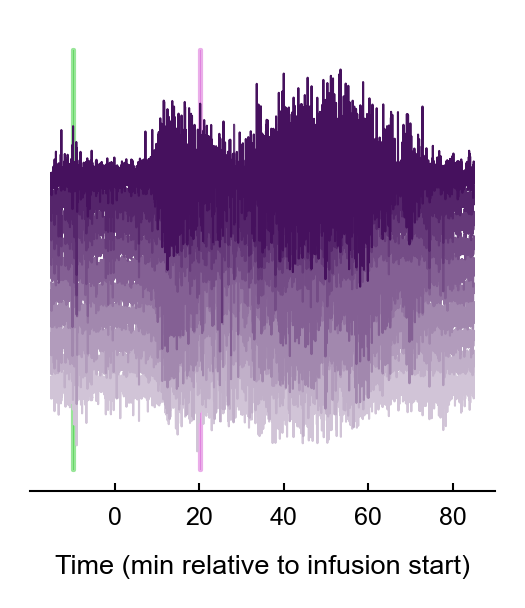

In [14]:
curve_color = cfg.plotting.curve_colors['propofol']
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

np.random.seed(42)
n_electrodes = downsampled_lfp.shape[1]
random_indices = np.random.choice(n_electrodes, size=10, replace=False)
offset = 0
delta = 1.5 * np.nanstd(downsampled_lfp[:, random_indices])  # vertical separation

# Create a colormap based on curve_color and show a spectrum
# We'll use a LinearSegmentedColormap between a lighter and deeper version of curve_color
base_color = mcolors.to_rgb(curve_color)
light_color = mcolors.to_rgb("white")
colors = [mcolors.to_hex(np.array(light_color)*(1.-w) + np.array(base_color)*w) for w in np.linspace(0.25, 1, 10)]
# alternatively, use a built-in colormap mapped to curve_color (with transparency overlay for base_color)

plt.figure(figsize=(2, 2))
for j, (i, color) in enumerate(zip(random_indices, colors)):
    plt.plot(downsampled_times, downsampled_lfp[:, i] + j * delta, label=f'Ch {i}', color=color)
plt.xlabel('Time (min relative to infusion start)')
# plt.ylabel('LFP (offset, a.u.)')
# get rid of y-axis spine
plt.gca().spines['left'].set_visible(False)
# plt.title('10 Random Downsampled Channels, Offset')
plt.yticks([])
# plt.legend(loc='best')
# fill between wake window start and end
ylim = plt.gca().get_ylim()
plt.fill_betweenx(ylim, (wake_window_start - infusion_start)/60, (wake_window_start + 15 - infusion_start)/60, color=cfg.plotting.epoch_colors['awake'], alpha=0.5)
# fill between anesthesia window start and end
plt.fill_betweenx(ylim, (anesthesia_window_start - infusion_start)/60, (anesthesia_window_start + 15 - infusion_start)/60, color=cfg.plotting.epoch_colors['anesthesia'], alpha=0.5)
# fill between contiguous valid window time ranges

# downsample hdf5 lfp from 1000 Hz to 100 Hz\
plt.savefig(os.path.join(img_save_dir, 'introduction', 'lfp_all_channels.pdf'), transparent=True, bbox_inches='tight')
plt.show()

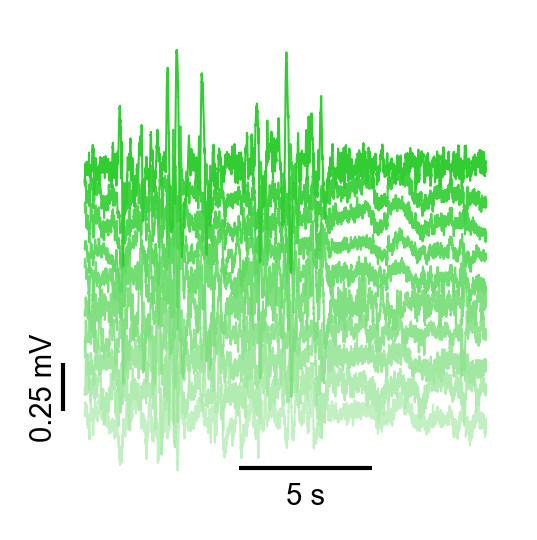

In [15]:
# Plot all random_indices offset, coloring them in a range relative to awake_color

import matplotlib.colors as mcolors
awake_color = cfg.plotting.epoch_colors['awake']
start_idx = int(wake_window_start / dt)
end_idx = int((wake_window_start + 15) / dt)
awake_rgb = mcolors.to_rgb(awake_color)
white_rgb = mcolors.to_rgb("white")
n_random = len(random_indices)
# Brighten the awake_color toward white for each channel
colors = [mcolors.to_hex(np.array(white_rgb)*(1.-w) + np.array(awake_rgb)*w) for w in np.linspace(0.3, 1, n_random)]

# Compute delta for vertical separation channel-wise (to avoid selection issues)
# Use only one channel per call to avoid h5py/h5py_utils fancy-index errors
deltas = [1.8 * np.nanstd(lfp[start_idx:end_idx, int(i)]) for i in random_indices]
delta = np.nanmean(deltas)  # use the mean of all channels' std for separation

fig, ax = plt.subplots(figsize=(2, 2))
for j, (i, color) in enumerate(zip(random_indices, colors)):
    y = lfp[start_idx:end_idx, int(i)]
    ax.plot(np.arange(y.shape[0]), y + j*delta, color=color, label=f"Ch {i}")
ax.spines['left'].set_visible(False)
ax.set_yticks([])

# Remove x axis entirely (no ticks, no label)
ax.set_xticks([])
ax.set_xlabel("")

# Add a scale bar (length = 5 s, placed at lower right)
# Find scale bar position
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
scale_bar_length = int(5 / dt)
if scale_bar_length > xmax - xmin:
    scale_bar_length = int((xmax - xmin) / 2)
bar_x = xmax - scale_bar_length - 5000
bar_y = ymin + 0.05 * (ymax - ymin)

# Draw horizontal line for scale bar (5 s)
ax.hlines(bar_y, bar_x, bar_x + scale_bar_length, color='k', linewidth=1, clip_on=False)
# Annotate scale bar duration
ax.text(bar_x + scale_bar_length/2, bar_y - 0.03*(ymax-ymin), "5 s", ha='center', va='top', fontsize=7)

# Add a vertical scale bar (e.g., 1 mV) at the same location
vertical_bar_height = 0.25  # 1 mV
bar_x_vert = xmin - 50   # a bit left of the right side, consistent with horizontal bar
bar_y_vert_bottom = bar_y + 0.3
bar_y_vert_top = bar_y_vert_bottom + vertical_bar_height

# Draw vertical line for scale bar (1 mV)
ax.vlines(bar_x_vert, bar_y_vert_bottom, bar_y_vert_top, color='k', linewidth=1, clip_on=False)
# Annotate vertical bar
ax.text(bar_x_vert - 0.04*scale_bar_length, (bar_y_vert_bottom + bar_y_vert_top)/2, "0.25 mV", 
        ha='right', va='center', rotation=90, fontsize=7)

# turn off x-axis spline
ax.spines['bottom'].set_visible(False)

plt.savefig(os.path.join(img_save_dir, 'introduction', 'lfp_window_wake.pdf'), transparent=True, bbox_inches='tight')
plt.show()

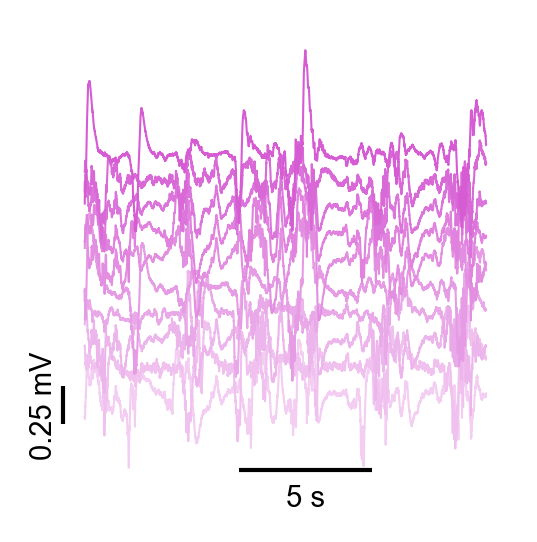

In [17]:
# Plot all random_indices offset, coloring them in a range relative to awake_color

import matplotlib.colors as mcolors
anesthesia_color = cfg.plotting.epoch_colors['anesthesia']
start_idx = int(anesthesia_window_start / dt)
end_idx = int((anesthesia_window_start + 15) / dt)
anesthesia_rgb = mcolors.to_rgb(anesthesia_color)
white_rgb = mcolors.to_rgb("white")
n_random = len(random_indices)
# Brighten the awake_color toward white for each channel
colors = [mcolors.to_hex(np.array(white_rgb)*(1.-w) + np.array(anesthesia_rgb)*w) for w in np.linspace(0.3, 1, n_random)]

# Compute delta for vertical separation channel-wise (to avoid selection issues)
# Use only one channel per call to avoid h5py/h5py_utils fancy-index errors
deltas = [1.5 * np.nanstd(lfp[start_idx:end_idx, int(i)]) for i in random_indices]
delta = np.nanmean(deltas)  # use the mean of all channels' std for separation

fig, ax = plt.subplots(figsize=(2, 2))
for j, (i, color) in enumerate(zip(random_indices, colors)):
    y = lfp[start_idx:end_idx, int(i)]
    ax.plot(np.arange(y.shape[0]), y + j*delta, color=color, label=f"Ch {i}")
ax.spines['left'].set_visible(False)
ax.set_yticks([])

# Remove x axis entirely (no ticks, no label)
ax.set_xticks([])
ax.set_xlabel("")

# Add a scale bar (length = 5 s, placed at lower right)
# Find scale bar position
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
scale_bar_length = int(5 / dt)
if scale_bar_length > xmax - xmin:
    scale_bar_length = int((xmax - xmin) / 2)
bar_x = xmax - scale_bar_length - 5000
bar_y = ymin + 0.04 * (ymax - ymin)

# Draw horizontal line for scale bar (5 s)
ax.hlines(bar_y, bar_x, bar_x + scale_bar_length, color='k', linewidth=1, clip_on=False)
# Annotate scale bar duration
ax.text(bar_x + scale_bar_length/2, bar_y - 0.03*(ymax-ymin), "5 s", ha='center', va='top', fontsize=7)
# turn of x-axis spline
ax.spines['bottom'].set_visible(False)

# Add a vertical scale bar (e.g., 1 mV) at the same location
vertical_bar_height = 0.25  # 1 mV
bar_x_vert = xmin - 50   # a bit left of the right side, consistent with horizontal bar
bar_y_vert_bottom = bar_y + 0.3
bar_y_vert_top = bar_y_vert_bottom + vertical_bar_height

# Draw vertical line for scale bar (1 mV)
ax.vlines(bar_x_vert, bar_y_vert_bottom, bar_y_vert_top, color='k', linewidth=1, clip_on=False)
# Annotate vertical bar
ax.text(bar_x_vert - 0.04*scale_bar_length, (bar_y_vert_bottom + bar_y_vert_top)/2, "0.25 mV", 
        ha='right', va='center', rotation=90, fontsize=7)

plt.savefig(os.path.join(img_save_dir, 'introduction', 'lfp_window_anesthesia.pdf'), transparent=True, bbox_inches='tight')
plt.show()

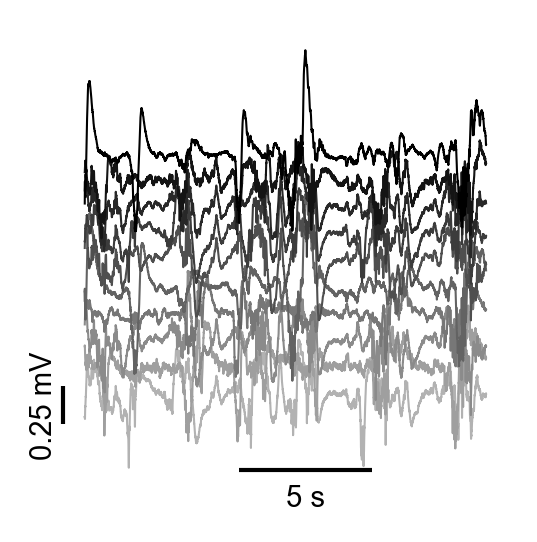

In [18]:
# Plot all random_indices offset, coloring them in a range relative to awake_color

import matplotlib.colors as mcolors
# anesthesia_color = cfg.plotting.epoch_colors['anesthesia']
anesthesia_color = 'k'
start_idx = int(anesthesia_window_start / dt)
end_idx = int((anesthesia_window_start + 15) / dt)
anesthesia_rgb = mcolors.to_rgb(anesthesia_color)
white_rgb = mcolors.to_rgb("white")
n_random = len(random_indices)
# Brighten the awake_color toward white for each channel
colors = [mcolors.to_hex(np.array(white_rgb)*(1.-w) + np.array(anesthesia_rgb)*w) for w in np.linspace(0.3, 1, n_random)]

# Compute delta for vertical separation channel-wise (to avoid selection issues)
# Use only one channel per call to avoid h5py/h5py_utils fancy-index errors
deltas = [1.5 * np.nanstd(lfp[start_idx:end_idx, int(i)]) for i in random_indices]
delta = np.nanmean(deltas)  # use the mean of all channels' std for separation

fig, ax = plt.subplots(figsize=(2, 2))
for j, (i, color) in enumerate(zip(random_indices, colors)):
    y = lfp[start_idx:end_idx, int(i)]
    ax.plot(np.arange(y.shape[0]), y + j*delta, color=color, label=f"Ch {i}")
ax.spines['left'].set_visible(False)
ax.set_yticks([])

# Remove x axis entirely (no ticks, no label)
ax.set_xticks([])
ax.set_xlabel("")

# Add a scale bar (length = 5 s, placed at lower right)
# Find scale bar position
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
scale_bar_length = int(5 / dt)
if scale_bar_length > xmax - xmin:
    scale_bar_length = int((xmax - xmin) / 2)
bar_x = xmax - scale_bar_length - 5000
bar_y = ymin + 0.04 * (ymax - ymin)

# Draw horizontal line for scale bar (5 s)
ax.hlines(bar_y, bar_x, bar_x + scale_bar_length, color='k', linewidth=1, clip_on=False)
# Annotate scale bar duration
ax.text(bar_x + scale_bar_length/2, bar_y - 0.03*(ymax-ymin), "5 s", ha='center', va='top', fontsize=7)
# turn of x-axis spline
ax.spines['bottom'].set_visible(False)

# Add a vertical scale bar (e.g., 1 mV) at the same location
vertical_bar_height = 0.25  # 1 mV
bar_x_vert = xmin - 50   # a bit left of the right side, consistent with horizontal bar
bar_y_vert_bottom = bar_y + 0.3
bar_y_vert_top = bar_y_vert_bottom + vertical_bar_height

# Draw vertical line for scale bar (1 mV)
ax.vlines(bar_x_vert, bar_y_vert_bottom, bar_y_vert_top, color='k', linewidth=1, clip_on=False)
# Annotate vertical bar
ax.text(bar_x_vert - 0.04*scale_bar_length, (bar_y_vert_bottom + bar_y_vert_top)/2, "0.25 mV", 
        ha='right', va='center', rotation=90, fontsize=7)

plt.savefig(os.path.join(img_save_dir, 'introduction', 'lfp_window_generic.pdf'), transparent=True, bbox_inches='tight')
plt.show()

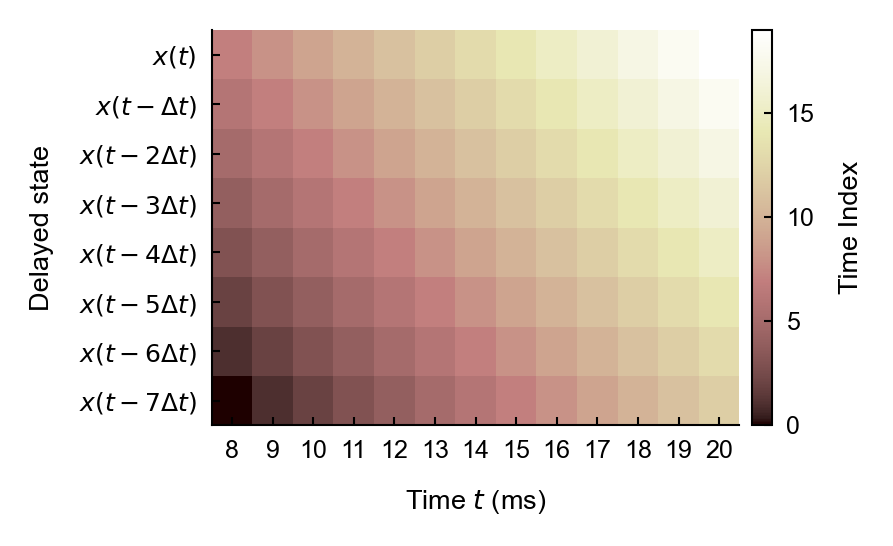

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 20      # Number of time points
p = 8       # Number of delays (columns in the Hankel/delay embedding matrix)

# Create colormap to assign a color for each time point
cmap = plt.cm.pink
normalize = plt.Normalize(0, T-1)
colors = cmap(normalize(np.arange(T)))

# Build Hankel/delay embedding matrix indices:
# Each row is [t, t+1, ..., t+p-1], for t in 0 to T-p
rows = T - p + 1
hankel_matrix = np.zeros((rows, p), dtype=int)
for i in range(rows):
    # hankel_matrix[i] = np.arange(i, i+p)
    hankel_matrix[i] = np.arange(i, i+p)[::-1]

# Plot the Hankel matrix TRANSPOSED: delays as rows, window as columns
fig, ax = plt.subplots(figsize=(3, 1.8))

for col in range(p):
    for row in range(rows):
        time_idx = hankel_matrix[row, col]
        # Transpose by swapping col and row when adding patches
        ax.add_patch(plt.Rectangle((row, col), 1, 1, color=colors[time_idx], ec='none'))
        # Optionally, show the time index inside the cell:
        # ax.text(row+0.5, col+0.5, str(time_idx+1), color='w' if normalize(time_idx)>0.5 else 'k', 
        #         va='center', ha='center', fontsize=7)

ax.set_xlim(0, rows)
ax.set_ylim(0, p)
ax.invert_yaxis()  # Optional, so lower delays at top

ax.set_xticks(np.arange(rows)+0.5)
ax.set_xticklabels([f"{i+p}" for i in range(rows)], rotation=0)
ax.set_yticks(np.arange(p)+0.5)
ax.set_yticklabels(["$x(t)$" if i == 0 else f"$x(t - {i if i != 1 else ''}\\Delta t)$" for i in range(p)])
ax.set_xlabel("Time $t$ (ms)")
ax.set_ylabel("Delayed state")
# ax.set_title("Transposed Delay Embedding (Hankel) Matrix\nwith Color-mapped Timepoints")

# Add colorbar for time index
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Time Index')

plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, 'introduction', 'hankel_matrix.pdf'), transparent=True, bbox_inches='tight')
plt.show()


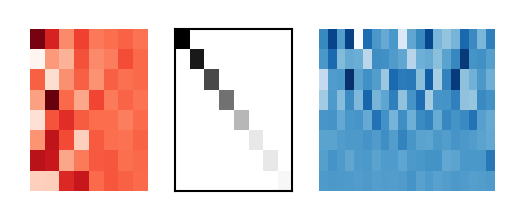

In [51]:
# Plot just U, Sigma, V^T matrices (no H, no equals sign)
fig = plt.figure(figsize=(2, 0.7))
gs = plt.GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1.5])

np.random.seed(42)

sigma = np.diag(np.sort(np.random.rand(p))[::-1])

# U Matrix
ax_u = fig.add_subplot(gs[0, 0])
U = np.random.randn(p, p)
# scale U by sigma
U = U @ sigma
ax_u.imshow(U, aspect='auto', cmap='Reds', interpolation='none')
# ax_u.set_title("$U$", fontsize=16)
ax_u.set_xticks([]); ax_u.set_yticks([])

# turn off spines
ax_u.spines['top'].set_visible(False)
ax_u.spines['right'].set_visible(False)
ax_u.spines['bottom'].set_visible(False)
ax_u.spines['left'].set_visible(False)

# Sigma Matrix

ax_sigma = fig.add_subplot(gs[0, 1])
ax_sigma.imshow(sigma, aspect='auto', cmap='Greys', interpolation='none')
# ax_sigma.set_title("$\\Sigma$", fontsize=16)
ax_sigma.set_xticks([]); ax_sigma.set_yticks([])

# turn on spines
ax_sigma.spines['top'].set_visible(True)
ax_sigma.spines['right'].set_visible(True)
ax_sigma.spines['bottom'].set_visible(True)
ax_sigma.spines['left'].set_visible(True)

# V^T Matrix
ax_v = fig.add_subplot(gs[0, 2])
V = np.random.randn(p, T)
# scale V by sigma
V = sigma @ V
ax_v.imshow(V, aspect='auto', cmap='Blues', interpolation='none')
# ax_v.set_title("$V^T$", fontsize=16)
ax_v.set_xticks([]); ax_v.set_yticks([])

# turn off spines
ax_v.spines['top'].set_visible(False)
ax_v.spines['right'].set_visible(False)
ax_v.spines['bottom'].set_visible(False)
ax_v.spines['left'].set_visible(False)
plt.savefig(os.path.join(img_save_dir, 'introduction', 'svd_matrices.pdf'), transparent=True, bbox_inches='tight')
plt.show()

In [58]:

session_list = [session]
areas = ['all']
pca_chosen = None
grid_params_to_use, grid_search_results = get_grid_params_to_use(cfg, session_list, areas, pca_chosen, log=None, return_results=True, verbose=True)

--------------------
SESSION = MrJones-Anesthesia-20160123-01
--------------------
list exists! loading /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/grid_searches/propofolPuffTone/grid_search_run_lists/MrJones-Anesthesia-20160123-01_grid_set6_window_15...
Loading data for MrJones-Anesthesia-20160123-01 - all from /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/grid_searches/propofolPuffTone/grid_search_results/MrJones-Anesthesia-20160123-01/NOISE_FILTERED_15_1_1_1_stride_15/NOT_NORMED/SUBSAMPLE_1/NO_FILTER/WINDOW_15/grid_set6/all/NO_PCA


  0%|          | 0/300 [00:00<?, ?it/s]

Results for session: MrJones-Anesthesia-20160123-01, area: all: n_delays=5, rank=1050


In [96]:
n_delays = grid_params_to_use[session][areas[0]]['n_delays']
rank = grid_params_to_use[session][areas[0]]['rank']
n_delays, rank


(5, 1050)

In [97]:
delase = DeLASE(lfp[int(wake_window_start/dt):int((wake_window_start+15)/dt), good_electrodes], n_delays=n_delays, rank=rank, device=device, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, dt=dt)
delase.fit()

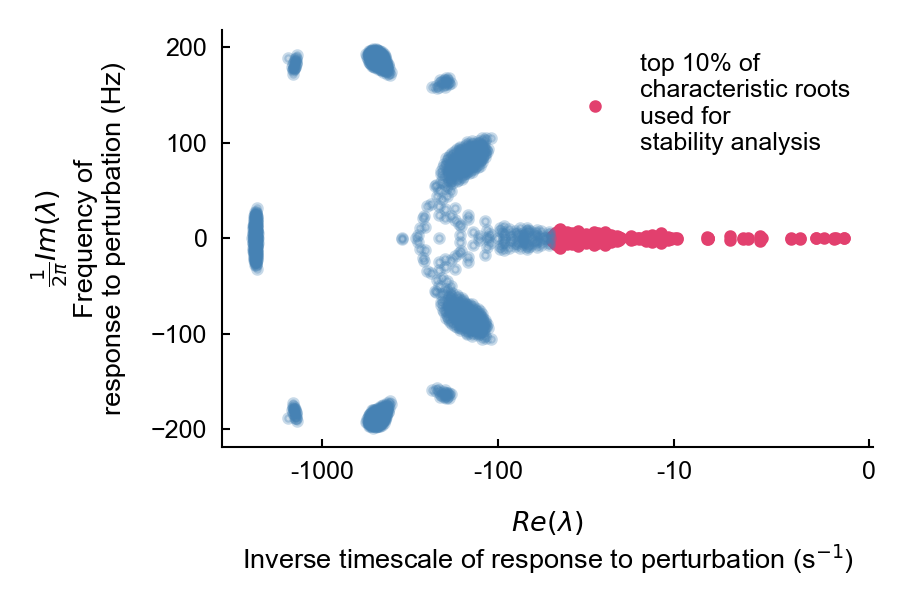

In [115]:
# "Log scale" for negative values is not possible by default, but we can plot the *magnitude* (absolute value) of the negative real parts on a log scale and manually flip the axis to indicate they're negative.
# We'll use a symlog scale for smoother behavior around zero.

top_percent = 0.1
stability_params = delase.stability_params.cpu().numpy()
stability_freqs = delase.stability_freqs.cpu().numpy()

top_percent_inds = np.argsort(stability_params)[-int(top_percent*len(stability_params)):]
bottom_percent_inds = np.argsort(stability_params)[:int((1 - top_percent)*len(stability_params))]

fig, ax = plt.subplots(figsize=(3, 2))

# Plot, flipping sign to show magnitude on log scale but x ticks will be negative
ax.scatter(stability_params[top_percent_inds], stability_freqs[top_percent_inds], label="top 10% of\ncharacteristic roots\nused for\nstability analysis", c="#E2406E")
ax.scatter(stability_params[bottom_percent_inds], stability_freqs[bottom_percent_inds], c="#4682B4", alpha=0.3)  # complementary blue

# Set xscale to symlog for better handling of values close to zero
ax.set_xscale('symlog', linthresh=10)  # linthresh can be adjusted

# Change the ticks back to negative values for proper labeling
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels(["-{:.0f}".format(-x) if x != 0 else "0" for x in xticks])

ax.set_xlabel("$Re(\\lambda)$\nInverse timescale of response to perturbation (s$^{-1}$)")
ax.set_ylabel("$\\frac{1}{2\\pi}Im(\\lambda)$\nFrequency of\nresponse to perturbation (Hz)")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, 'introduction', 'stability_scatter_logx.pdf'), transparent=True, bbox_inches='tight')
plt.show()


In [15]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [-36.120676111111116, -26.045618333333337]


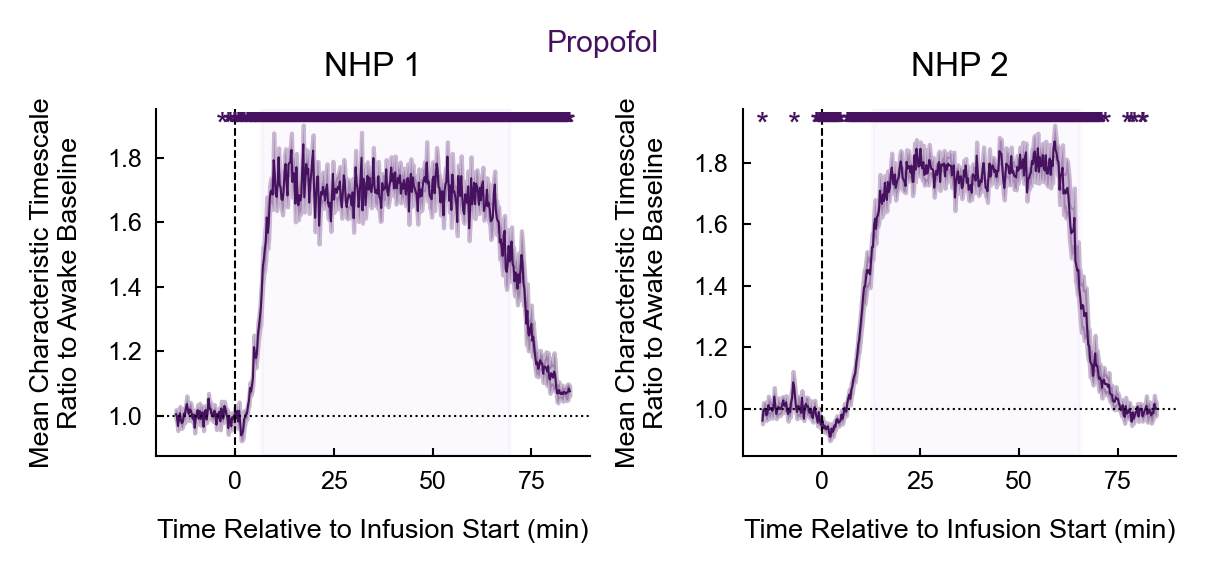

In [22]:
plot_data = {}
dose = 'high'
area = 'all'
top_percent = 0.1
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
for (data_class, agent), data_dict in agent_data.items():
    # area = 'vlPFC' if agent == 'propofol' else 'vlPFC-L'
    # area = 'FEF' if agent == 'propofol' else 'vlPFC-R'
    # area = '7b' if agent == 'propofol' else 'dlPFC-R'
    # area = 'CPB' if agent == 'propofol' else 'dlPFC-L'
    if agent == 'propofol':
        plot_range = (-15, 85)
    elif agent == 'ketamine':
        plot_range = (-30, 220)
    else:
        plot_range = (-30, 180)
    if dose == 'high':
        save_path = os.path.join(img_save_dir, f"{agent}_timescales_grouped_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
    else:
        save_path = os.path.join(img_save_dir, f"{agent}_timescales_grouped_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
    cfg.params.data_class = data_class
    plot_data[(data_class, agent)] = plot_session_stability_grouped(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        data_dict['delase_results'], 
        data_dict['locs'], 
        data_dict['rocs'], 
        data_dict['ropaps'],
        timescales=True,
        plot_range=plot_range, 
        top_percent=top_percent, 
        curve_colors=curve_colors, 
        loc_roc_colors=loc_roc_colors, 
        figsize=(4, 2),
        dose=dose,
        save_path=save_path,
        verbose=True,
        area=area,
        return_data=True
    )
    break


In [41]:
common_times = plot_data[(data_class, agent)]['common_times']
# inverse_timescales = plot_data[(data_class, agent)]['groups']['MrJones']['high']['per_session'][session]['aligned_inverse_timescales']
inverse_timescales = plot_data[(data_class, agent)]['groups']['MrJones']['high']['aligned_data_inverse_timescales']

In [46]:
section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')

In [52]:
np.where([s[0] == 'Awake' for s in section_info])[0][0]

0

In [54]:
awake_section

[-15, 0]

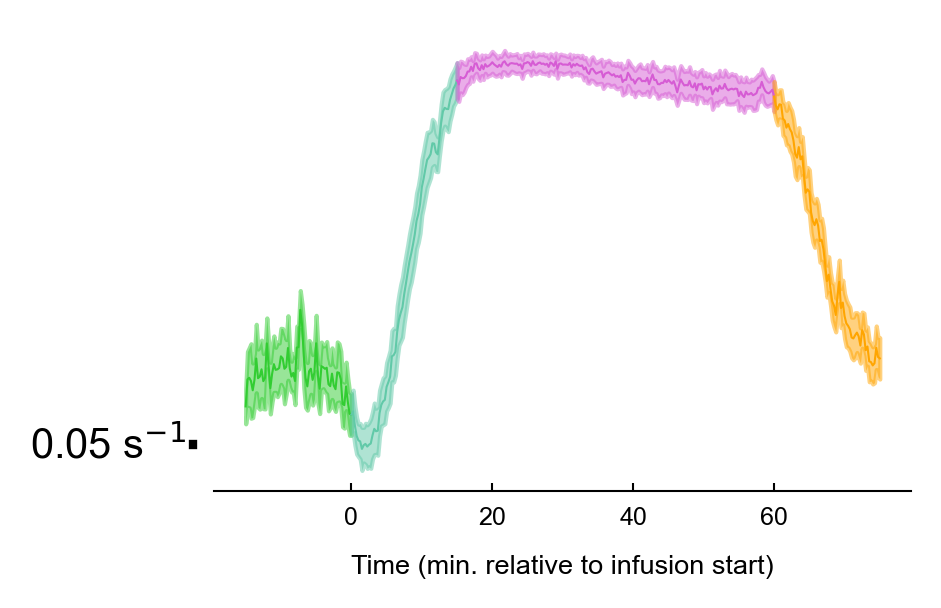

In [ ]:
from scipy.stats import sem

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory

# Prepare axes
fig, ax = plt.subplots(figsize=(3, 2))  # Optional: Specify size if desired

# Awake section
awake_section = section_info[np.where([s[0] == 'Awake' for s in section_info])[0][0]][1]
time_bool = (common_times >= awake_section[0]) & (common_times <= awake_section[1])
awake_color = cfg.plotting.epoch_colors['awake']
mean_vals = inverse_timescales.mean(axis=0)[time_bool]
sem_vals = sem(inverse_timescales, axis=0)[time_bool]
ax.plot(common_times[time_bool], mean_vals, c=awake_color, label='Awake')
ax.fill_between(common_times[time_bool], mean_vals - sem_vals, mean_vals + sem_vals, color=awake_color, alpha=0.5)

# Induction section
induction_section = section_info[np.where([s[0] == 'Induction' for s in section_info])[0][0]][1]
time_bool = (common_times >= induction_section[0]) & (common_times <= induction_section[1])
induction_color = cfg.plotting.epoch_colors['induction']
mean_vals = inverse_timescales.mean(axis=0)[time_bool]
sem_vals = sem(inverse_timescales, axis=0)[time_bool]
ax.plot(common_times[time_bool], mean_vals, c=induction_color, label='Induction')
ax.fill_between(common_times[time_bool], mean_vals - sem_vals, mean_vals + sem_vals, color=induction_color, alpha=0.5)

# Anesthesia section
anesthesia_section = section_info[np.where([s[0] == 'Anesthesia' for s in section_info])[0][0]][1]
time_bool = (common_times >= anesthesia_section[0]) & (common_times <= anesthesia_section[1])
anesthesia_color = cfg.plotting.epoch_colors['anesthesia']
mean_vals = inverse_timescales.mean(axis=0)[time_bool]
sem_vals = sem(inverse_timescales, axis=0)[time_bool]
ax.plot(common_times[time_bool], mean_vals, c=anesthesia_color, label='Anesthesia')
ax.fill_between(common_times[time_bool], mean_vals - sem_vals, mean_vals + sem_vals, color=anesthesia_color, alpha=0.5)

# Emergence section
emergence_section = section_info[np.where([s[0] == 'Emergence' for s in section_info])[0][0]][1]
time_bool = (common_times >= emergence_section[0]) & (common_times <= emergence_section[1])
emergence_color = cfg.plotting.epoch_colors['emergence']
mean_vals = inverse_timescales.mean(axis=0)[time_bool]
sem_vals = sem(inverse_timescales, axis=0)[time_bool]
ax.plot(common_times[time_bool], mean_vals, c=emergence_color, label='Emergence')
ax.fill_between(common_times[time_bool], mean_vals - sem_vals, mean_vals + sem_vals, color=emergence_color, alpha=0.5)

# Add vertical scale bar in units of s^{-1}
scalebar_height = 5 # in s^{-1}
ymin, ymax = ax.get_ylim()
scalebar_y = ymin + 0.10 * (ymax - ymin)  # 10% up from bottom

# Place the scale bar just to the left of the y-axis using a blended transform
trans = blended_transform_factory(ax.transAxes, ax.transData)
x_axes = -0.03  # 3% to the left of the axis
ax.plot([x_axes, x_axes], [scalebar_y, scalebar_y + scalebar_height],
        color='k', lw=2, clip_on=False, transform=trans)
ax.text(x_axes - 0.01, scalebar_y + scalebar_height / 2,
        f'{scalebar_height} s$^{{-1}}$', va='center', ha='right',
        fontsize=10, transform=trans)

# turn off y axis spines
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# turn of yticks
ax.set_yticks([])

ax.legend(loc='upper left', bbox_to_anchor=(0.9, 0.95), fontsize=7)

ax.set_xlabel("Time (min. relative to infusion start)")
plt.savefig(os.path.join(img_save_dir, 'introduction', 'inverse_timescales_with_scalebar.pdf'), transparent=True, bbox_inches='tight')
plt.show()